In [1]:
import pandas as pd
import torch
import os

def is_running_on_kaggle():
    return 'KAGGLE_URL_BASE' in os.environ

print('Running on Kaggle' if is_running_on_kaggle() else 'Running on local machine')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Running on local machine
Using cuda device


In [2]:
DATA_PATH = '/kaggle/input/sentiment-analysis-dataset/' if is_running_on_kaggle() else 'data/'
TRAIN_FILE = DATA_PATH + 'train.csv'
TEST_FILE = DATA_PATH + 'test.csv'
TRAIN_SPLIT = 0.8
BLOCK_SIZE = 32

In [3]:
torch.manual_seed(0)

In [4]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
for word in ['not', 'no', 'nor']:
    stop_words.remove(word)

In [5]:
from nltk.stem import PorterStemmer
import nltk
import preprocessor as p
import string
import re
import contractions

def clean_tweet(row):
    text = row['text']
    p.set_options(p.OPT.URL, p.OPT.EMOJI)
    clean_text = p.clean(text)
    lower_text = clean_text.lower()
    
    expanded_text = contractions.fix(lower_text)
    fixed_text = expanded_text.replace('[^\w\s]',' ').replace('\s\s+', ' ').translate(str.maketrans('', '', string.punctuation))
    return fixed_text

def tokenize_tweet(row):
    text = row['cleaned_text']
    tokens = p.tokenize(text).split()
    st = PorterStemmer()
    tokens = [st.stem(word) for word in tokens]
    filtered_tokens = [w for w in tokens if not w in stop_words]
    return filtered_tokens

In [6]:
# df.head(10)

In [7]:
# df['cleaned_text']= df.apply(clean_tweet, axis=1)
# df.head(10)

In [8]:
# df['tokens'] = df.apply(tokenize_tweet, axis=1)
# df.head(10)

In [9]:
import torch
import random
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, file_path, vocab=None):
        self.data = pd.read_csv(file_path)
        self.data['cleaned_text'] = self.data.apply(clean_tweet, axis=1)
        self.data['tokens'] = self.data.apply(tokenize_tweet, axis=1)
        if vocab is None:
            self.build_vocab()
        else:
            self.vocab = vocab
        # self.block_size = self.data['tokens'].apply(len).max()
        self.data['encoding'] = self.data['tokens'].apply(self.encode_sentence)
        if 'sentiment' in self.data.columns:
            self.data['label'] = torch.tensor(self.data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0 if x == 'neutral' else 2))
    
    def build_vocab(self):
        all_tokens = set([token for tokens in self.data['tokens'] for token in tokens])
        vocab = {token: i for i, token in enumerate(all_tokens)}
        vocab['<UNK>'] = len(vocab)
        self.vocab = vocab

    def encode_sentence(self, tokens):
        encoded = torch.tensor([self.vocab[token] if token in self.vocab else self.vocab['<UNK>'] for token in tokens], dtype=torch.long)
        pos = [True] * len(encoded) + [False] * (BLOCK_SIZE-len(encoded))
        random.shuffle(pos)
        padded = torch.ones(BLOCK_SIZE, dtype=torch.long) * self.vocab['<UNK>']
        i = 0
        for j, p in enumerate(pos):
            if p:
                padded[j] = encoded[i]
                i += 1
        return padded

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        encoding = self.data.loc[idx, 'encoding']
        label = self.data.loc[idx, 'label'] if 'label' in self.data.columns else None
        return encoding, label

# Create an instance of the TrainingDataset
dataset = SentimentDataset(TRAIN_FILE)

In [10]:
print(f"Number of samples in the dataset: {len(dataset)}")
print(f"Vocabulary size: {len(dataset.vocab)}")
print(f"First 5 encoded samples:\n{dataset.data['encoding'][:5]}, {dataset.data['label'][:5]}")

Number of samples in the dataset: 24732
Vocabulary size: 21150
First 5 encoded samples:
0    [tensor(21149), tensor(21149), tensor(21149), ...
1    [tensor(21149), tensor(7907), tensor(21149), t...
2    [tensor(21149), tensor(21149), tensor(21149), ...
3    [tensor(21149), tensor(21149), tensor(21149), ...
4    [tensor(21149), tensor(21149), tensor(21149), ...
Name: encoding, dtype: object, 0    1
1    0
2    2
3    2
4    2
Name: label, dtype: int64


In [11]:
from torch.utils.data import random_split

# Define the sizes of training and validation sets
train_size = int(TRAIN_SPLIT * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_data, val_data = random_split(dataset, [train_size, val_size])

# Print the sizes of the training and validation sets
print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))

Training set size: 19785
Validation set size: 4947


In [12]:
display(train_data[:10])

(3320     [tensor(21149), tensor(21149), tensor(3014), t...
 18673    [tensor(21149), tensor(21149), tensor(21149), ...
 1635     [tensor(21149), tensor(3666), tensor(21149), t...
 6306     [tensor(21149), tensor(21149), tensor(21149), ...
 463      [tensor(21149), tensor(11782), tensor(21149), ...
 6117     [tensor(21149), tensor(21149), tensor(21149), ...
 13711    [tensor(21149), tensor(21149), tensor(21149), ...
 16635    [tensor(8979), tensor(21149), tensor(21149), t...
 20725    [tensor(21149), tensor(21149), tensor(5132), t...
 17271    [tensor(21149), tensor(21149), tensor(21149), ...
 Name: encoding, dtype: object,
 3320     2
 18673    0
 1635     0
 6306     0
 463      1
 6117     0
 13711    0
 16635    2
 20725    1
 17271    0
 Name: label, dtype: int64)

In [13]:
import torch.nn as nn
from torch.nn import functional as F

class SelfAttentionHead(nn.Module):
    def __init__(self, size_embd, size_head):
        super(SelfAttentionHead, self).__init__()
        self.size_embd = size_embd
        self.size_head = size_head
        self.query = nn.Linear(size_embd, size_head)
        self.key = nn.Linear(size_embd, size_head)
        self.value = nn.Linear(size_embd, size_head)
    
    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        wei = torch.matmul(q, k.transpose(1, 2)) / (self.size_embd ** 0.5)
        # tril = torch.tril(torch.ones(wei.size(-1), wei.size(-1), device=device))
        # wei = wei.masked_fill(tril == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)

        return torch.matmul(wei, v)

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, size_embd):
        super().__init__()
        self.tok_embd = nn.Embedding(vocab_size, size_embd)
        self.pos_embd = nn.Embedding(BLOCK_SIZE, size_embd)
        self.sa_head = SelfAttentionHead(size_embd, size_embd)
        self.fc = nn.Linear(size_embd, 3)

    
    def forward(self, x):
        # print(x.shape)
        te = self.tok_embd(x)
        pe = self.pos_embd(torch.arange(te.shape[1], device=device))
        x = te + pe
        # print(x.shape)
        
        x = self.sa_head(x)
        # print(x.shape)
        x = self.fc(x)
        x = x.mean(dim=1)
        x = F.softmax(x, dim=1)
        return x

In [15]:
class TransformerSentimentModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes, num_heads, hidden_dim, num_layers, max_seq_len):
        super(TransformerSentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_len, embed_size))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size,
                                                   nhead=num_heads,
                                                   dim_feedforward=hidden_dim,
                                                   dropout=0.2)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_size, num_classes)

    def forward(self, src, src_key_padding_mask=None):
        src = self.embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src = src.permute(1, 0, 2)  # (S, N, E) for transformer
        output = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask)
        output = output.mean(dim=0)  # Global average pooling
        output = self.fc(output)
        return output

In [41]:
from sklearn.metrics import f1_score, confusion_matrix

torch.manual_seed(0)

lrs = [2e-4, 5e-4, 1e-3]
embed_sizes = [24, 36, 48]
num_heads = [2, 4, 6]
num_layers = [3, 4, 5, 6]

for lr in lrs:
    for es in embed_sizes:
        for nh in num_heads:
            for nl in num_layers:
                                

                # model = SentimentClassifier(len(dataset.vocab), 128)
                model = TransformerSentimentModel(vocab_size=len(dataset.vocab),
                                                  embed_size=es,
                                                  num_classes=3,
                                                  num_heads=nh,
                                                  hidden_dim=2048,
                                                  num_layers=nl,
                                                  max_seq_len=BLOCK_SIZE)
                model.to(device)

                criterion = nn.CrossEntropyLoss().to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
                val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=True)

                epochs = 8
                all_train_loss = []
                all_val_loss = []
                all_train_f1 = []
                all_val_f1 = []
                for epoch in range(epochs):
                    model.train()
                    train_loss = 0.0
                    all_train_preds = []
                    all_train_labels = []
                    for inputs, labels in train_dataloader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        train_loss += loss.item()
                        preds = torch.argmax(outputs, dim=1)
                        all_train_preds.extend(preds.cpu().numpy())
                        all_train_labels.extend(labels.cpu().numpy())
                    train_loss /= len(train_dataloader)
                    f1 = f1_score(all_train_labels, all_train_preds, average='macro')
                    all_train_loss.append(train_loss)
                    all_train_f1.append(f1)

                    
                    model.eval()
                    val_loss = 0.0
                    all_preds = []
                    all_labels = []
                    with torch.no_grad():
                        for inputs, labels in val_dataloader:
                            inputs, labels = inputs.to(device), labels.to(device)
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                            val_loss += loss.item()
                            
                            preds = torch.argmax(outputs, dim=1)
                            all_preds.extend(preds.cpu().numpy())
                            all_labels.extend(labels.cpu().numpy())
                    val_loss /= len(val_dataloader)                    
                    f1 = f1_score(all_labels, all_preds, average='macro')
                    all_val_loss.append(val_loss)
                    all_val_f1.append(f1)
                
                print(f'LR: {lr}, Embed Size: {es}, Num Heads: {nh}, Num Layers: {nl}')
                best_val_loss_idx = all_val_loss.index(min(all_val_loss))
                best_val_loss = all_val_loss[best_val_loss_idx]
                best_f1_idx = all_val_f1.index(max(all_val_f1))
                best_f1 = all_val_f1[best_f1_idx]
                print(f'Best Validation Loss: {best_val_loss}, Best F1: {best_f1}')
                print(f'Best Validation Loss Epoch: {best_val_loss_idx+1}, Best F1 Epoch: {best_f1_idx+1}')

/home/andrewl73/anaconda3/envs/AML/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


KeyboardInterrupt: 

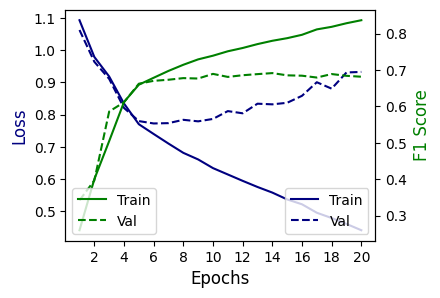

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

ax.plot(range(1, epochs+1), all_train_loss, label='Train', color='navy', linestyle='-')
ax.plot(range(1, epochs+1), all_val_loss, label='Val', color='navy', linestyle='--')
ax.set_xlabel('Epochs', fontdict={'size': 12})
ax.set_ylabel('Loss', color='navy', fontdict={'size': 12})
ax.legend(loc='lower right')

ax.set_xticks(range(0, epochs+1, 2))

ax1 = ax.twinx()
ax1.plot(range(1, epochs+1), all_train_f1, label='Train', color='green', linestyle='-')
ax1.plot(range(1, epochs+1), all_val_f1, label='Val', color='green', linestyle='--')
ax1.set_ylabel('F1 Score', color='green', fontdict={'size': 12})
ax1.legend(loc='lower left')

plt.show()

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

torch.manual_seed(0)




# model = SentimentClassifier(len(dataset.vocab), 128)
model = TransformerSentimentModel(vocab_size=len(dataset.vocab),
                                  embed_size=36,
                                  num_classes=3,
                                  num_heads=6,
                                  hidden_dim=2048,
                                  num_layers=4,
                                  max_seq_len=BLOCK_SIZE)
model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=True)

epochs = 8
all_train_loss = []
all_val_loss = []
all_train_f1 = []
all_val_f1 = []
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    all_train_preds = []
    all_train_labels = []
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())
    train_loss /= len(train_dataloader)
    f1 = f1_score(all_train_labels, all_train_preds, average='macro')
    all_train_loss.append(train_loss)
    all_train_f1.append(f1)

    
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_loss /= len(val_dataloader)
    
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)
    acc = sum([1 if p == l else 0 for p, l in zip(all_preds, all_labels)]) / len(all_preds)
    
    print(f"Epoch {epoch+1}/{epochs}\t=>\tTrain Loss: {train_loss:.4f},\tValidation Loss: {val_loss:.4f},\tF1: {f1:.4f},\tAccuracy: {acc:.4f}")
    display(cm)

    all_val_loss.append(val_loss)
    all_val_f1.append(f1)